## 没有特征的时间序列

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0)

In [2]:
print(df)

                     value
timestamp                 
2015-02-26 21:42:53     57
2015-02-26 21:47:53     43
2015-02-26 21:52:53     55
2015-02-26 21:57:53     64
2015-02-26 22:02:53     93
...                    ...
2015-04-22 20:32:53     51
2015-04-22 20:37:53     54
2015-04-22 20:42:53     46
2015-04-22 20:47:53     56
2015-04-22 20:52:53     50

[15831 rows x 1 columns]


In [4]:
print(df.index[0])

2015-02-26 21:42:53


In [5]:
print(df.value[:"2015-02-27 00:00:00"])

timestamp
2015-02-26 21:42:53     57
2015-02-26 21:47:53     43
2015-02-26 21:52:53     55
2015-02-26 21:57:53     64
2015-02-26 22:02:53     93
2015-02-26 22:07:53    104
2015-02-26 22:12:53     89
2015-02-26 22:17:53     87
2015-02-26 22:22:53     57
2015-02-26 22:27:53     68
2015-02-26 22:32:53     64
2015-02-26 22:37:53     61
2015-02-26 22:42:53     73
2015-02-26 22:47:53     79
2015-02-26 22:52:53     80
2015-02-26 22:57:53     76
2015-02-26 23:02:53     49
2015-02-26 23:07:53     59
2015-02-26 23:12:53     55
2015-02-26 23:17:53     48
2015-02-26 23:22:53     41
2015-02-26 23:27:53     49
2015-02-26 23:32:53     63
2015-02-26 23:37:53     36
2015-02-26 23:42:53     42
2015-02-26 23:47:53     50
2015-02-26 23:52:53     35
2015-02-26 23:57:53     41
Name: value, dtype: int64


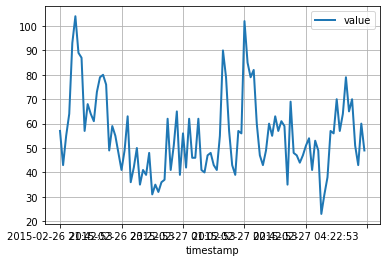

In [6]:
import matplotlib.pyplot as plt
df[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

In [ ]:
'''
每个数据集是一个可迭代的字典集合，每个字典表示一个带有相关特征的时间序列
生成训练集
"start"表示第一个数据点的时间戳，"target"包含时间序列数据。对于训练，我们使用直到2015.4.5的数据
'''

In [7]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2015-04-05 00:00:00"]}],
    freq = "5min"
)

In [ ]:
'''
GluonTS中的预测模型是一个predictor对象。例子中使用的是5分钟数据，所以freq="5min"，模型是要去预测下一个小时，所以prediction_length=12。在训练过程中有用的信息会输出
'''

In [ ]:
'''
DeepAREstimator
参数:
    use_feat_dynamic_real: 是否使用数据中的``feat_dynamic_real``字段，默认False
context_length默认等于prediction_length
history_length等于context_length + max(lags_seq)
lags_seq默认为get_lags_for_frequency(freq_str=freq)，得到一个lags的list
time_features默认为time_features_from_frequency_str(self.freq)，得到一个time features的list
方法:
    train(): 接受训练数据，返回一个predictor对象
'''

In [ ]:
'''
Trainer
'''

In [8]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(freq="5min", prediction_length=12, trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:04<00:00, 10.32it/s, epoch=10/10, avg_epoch_loss=3.95]


In [11]:
print(estimator.lags_seq)

[1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 34, 35, 36, 37, 38, 287, 288, 289, 575, 576, 577, 863, 864, 865, 1151, 1152, 1153]


In [12]:
print(estimator.history_length)

1165


In [13]:
print(estimator.time_features)

[gluonts.time_feature._base.MinuteOfHour(normalized=True), gluonts.time_feature._base.HourOfDay(normalized=True), gluonts.time_feature._base.DayOfWeek(normalized=True), gluonts.time_feature._base.DayOfMonth(normalized=True), gluonts.time_feature._base.DayOfYear(normalized=True)]


In [ ]:
'''
预测2015.4.15之后的一个小时
'''

In [9]:
test_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2015-04-15 00:00:00"]}],
    freq = "5min"
)

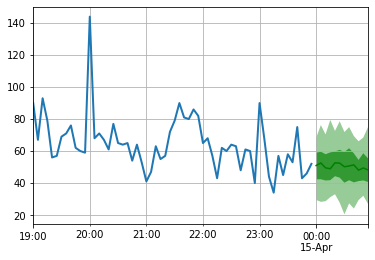

In [10]:
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-60:].plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0]) # 50%和90%的预测区间
plt.grid(which='both')

## 具有随时间变化的实数特征的时间序列

In [14]:
import numpy as np
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minusPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))

    pattern = np.concatenate(
        (
            np.tile(
                sin_minusPi_Pi.reshape(1, -1),
                (int(np.ceil(num_series / 2)),1)
            ),
            np.tile(
                sin_Zero_2Pi.reshape(1, -1),
                (int(np.floor(num_series / 2)), 1)
            )
        ),
        axis=0
    )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate(
        (
            np.zeros((num_series, period)),
            target[:, :-period]
        ),
        axis=1
    )

    return target, feat_dynamic_real

In [24]:
# define the parameters of the dataset
custom_ds_metadata = {'num_series': 1,
                      'num_steps': 24 * 7,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H')
                                for _ in range(100)]
                     }

In [25]:
data_out = create_dataset(custom_ds_metadata['num_series'],
                          custom_ds_metadata['num_steps'],
                          custom_ds_metadata['prediction_length']
                         )

target, feat_dynamic_real = data_out

In [26]:
from gluonts.dataset.field_names import FieldName
train_ds = ListDataset([{FieldName.TARGET: target,
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_REAL: [fdr]}
                         for (target, start, fdr) in zip(target[:, :-custom_ds_metadata['prediction_length']],
                                                             custom_ds_metadata['start'],
                                                             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']])],
                      freq=custom_ds_metadata['freq'])

In [27]:
test_ds = ListDataset([{FieldName.TARGET: target,
                        FieldName.START: start,
                        FieldName.FEAT_DYNAMIC_REAL: [fdr]}
                       for (target, start, fdr) in zip(target,
                                                            custom_ds_metadata['start'],
                                                            feat_dynamic_real)],
                     freq=custom_ds_metadata['freq'])

In [28]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])

In [29]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'source'])

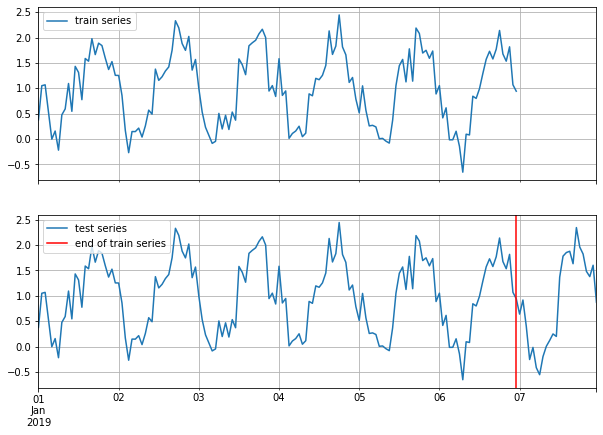

In [30]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()


In [31]:
estimator = DeepAREstimator(freq="1H", prediction_length=24, trainer=Trainer(epochs=10))
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:07<00:00,  7.01it/s, epoch=10/10, avg_epoch_loss=-.793]


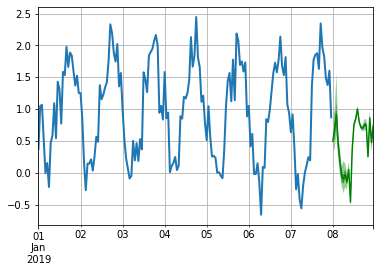

In [32]:
for test_entry, forecast in zip(test_ds, predictor.predict(test_ds)):
    to_pandas(test_entry).plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0]) # 50%和90%的预测区间
plt.grid(which='both')

In [ ]:
'''
令模型参数use_feat_dynamic_real为真，使用数据中的``feat_dynamic_real``字段
'''

In [33]:
estimator = DeepAREstimator(freq="1H", prediction_length=24, trainer=Trainer(epochs=10), use_feat_dynamic_real=True)
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:06<00:00,  7.66it/s, epoch=10/10, avg_epoch_loss=-.766]


In [34]:
for test_entry, forecast in zip(test_ds, predictor.predict(test_ds)):
    to_pandas(test_entry).plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0]) # 50%和90%的预测区间
plt.grid(which='both')

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 192 and the array at index 2 has size 168